In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cb06balapriyanr","key":"9bc33b78050c9095ca05cd601e386a85"}'}

In [3]:
! mkdir ~/.Kaggle


In [4]:
!cp kaggle.json ~/.kaggle/


cp: cannot create regular file '/root/.kaggle/': Not a directory


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [12]:
!kaggle datasets download -d simranvolunesia/pest-dataset

Dataset URL: https://www.kaggle.com/datasets/simranvolunesia/pest-dataset
License(s): CC0-1.0
pest-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!unzip pest-dataset.zip

Archive:  pest-dataset.zip
  inflating: pest/test/aphids/jpg_0 - Copy.jpg  
  inflating: pest/test/aphids/jpg_0.jpg  
  inflating: pest/test/aphids/jpg_11 - Copy.jpg  
  inflating: pest/test/aphids/jpg_11.jpg  
  inflating: pest/test/aphids/jpg_13 - Copy.jpg  
  inflating: pest/test/aphids/jpg_13.jpg  
  inflating: pest/test/aphids/jpg_15 - Copy.jpg  
  inflating: pest/test/aphids/jpg_15.jpg  
  inflating: pest/test/aphids/jpg_16.jpg  
  inflating: pest/test/aphids/jpg_19.jpg  
  inflating: pest/test/aphids/jpg_2 - Copy.jpg  
  inflating: pest/test/aphids/jpg_2.jpg  
  inflating: pest/test/aphids/jpg_23.jpg  
  inflating: pest/test/aphids/jpg_24.jpg  
  inflating: pest/test/aphids/jpg_25.jpg  
  inflating: pest/test/aphids/jpg_27.jpg  
  inflating: pest/test/aphids/jpg_29.jpg  
  inflating: pest/test/aphids/jpg_30.jpg  
  inflating: pest/test/aphids/jpg_32.jpg  
  inflating: pest/test/aphids/jpg_33.jpg  
  inflating: pest/test/aphids/jpg_35.jpg  
  inflating: pest/test/aphids/jpg_36.jp

In [74]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [75]:
IMAGE_SIZE=256
BATCH_SIZE= 8
CHANNELS=3
EPOCHS=8

In [76]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/pest/train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2700 files belonging to 9 classes.


In [77]:
class_names=dataset.class_names
class_names

['aphids',
 'armyworm',
 'beetle',
 'bollworm',
 'grasshopper',
 'mites',
 'mosquito',
 'sawfly',
 'stem_borer']

In [78]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(8, 256, 256, 3)
[3 0 7 2 6 8 0 7]


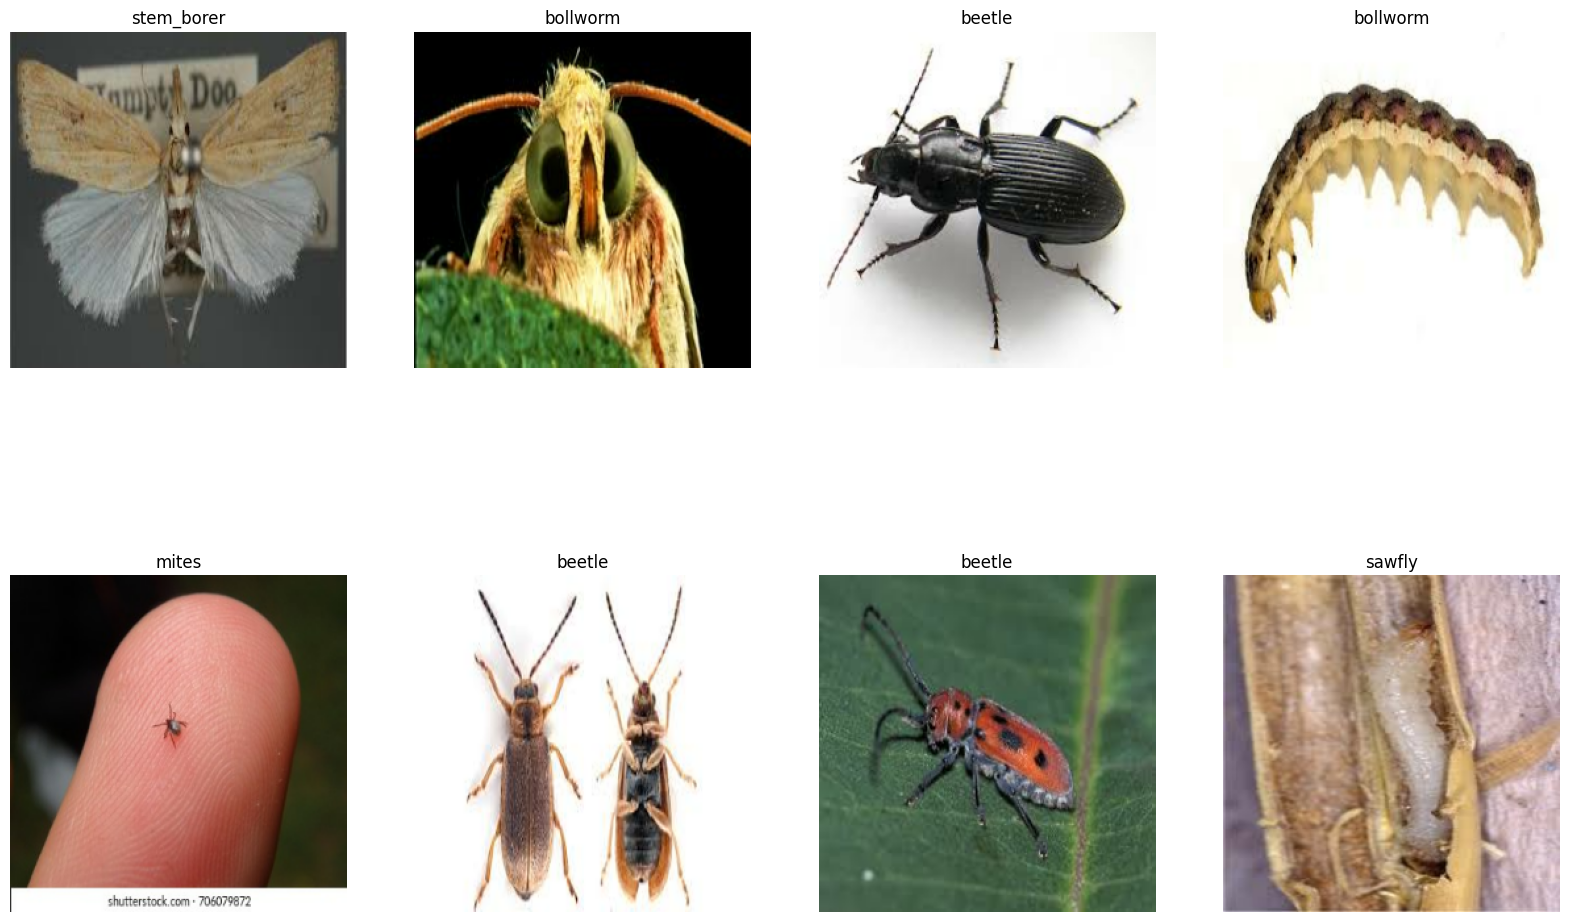

In [79]:
plt.figure(figsize=(20, 20))

# Extract a single batch
for image_batch, label_batch in dataset.take(1):
    batch_size = image_batch.shape[0]  # Get actual batch size
    for i in range(min(12, batch_size)):  # Ensure we don't exceed batch size
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

plt.show()  # Ensure the figure displays properly


In [80]:
train_size=0.8
len(dataset)*train_size

270.40000000000003

In [81]:
train_ds=dataset.take(45)
len(train_ds)

45

In [82]:
test_ds=dataset.skip(45)
len(test_ds)

293

In [83]:
val_size=0.1
len(dataset)*val_size

33.800000000000004

In [84]:
val_ds=test_ds.take(5)
len(val_ds)

5

In [85]:
test_ds=test_ds.skip(5)
len(test_ds)


288

In [86]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size= len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [87]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [88]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [89]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [90]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

])

In [91]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [95]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

IMAGE_SIZE = 256
CHANNELS = 3
NUM_CLASSES = 9

base_model = applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights='imagenet'
)

<ipython-input-95-3e39b95bf90c>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


In [96]:
base_model.trainable = False

In [99]:
model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),

    # Apply Augmentation
    data_augmentation,

    # Rescale pixel values
    layers.Rescaling(1./255),

    # MobileNetV2 Feature Extractor
    base_model,

    # Global Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

In [100]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [101]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,918,473 (11.13 MB)

 Trainable params: 660,489 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [102]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [103]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 178s 608ms/step - accuracy: 0.4395 - loss: 1.7470 - val_accuracy: 0.8409 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 2/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 163s 603ms/step - accuracy: 0.7554 - loss: 0.7294 - val_accuracy: 0.8939 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 3/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 576ms/step - accuracy: 0.8092 - loss: 0.5565 - val_accuracy: 0.9318 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 4/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 157s 580ms/step - accuracy: 0.8619 - loss: 0.3944 - val_accuracy: 0.9432 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 5/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 162s 601ms/step - accuracy: 0.8783 - loss: 0.3728 - val_accuracy: 0.9470 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 6/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 156s 578ms/step - accuracy: 0.8931 - loss: 0.3055 - val_accuracy: 0.9318 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 7/8
270/270 ━━━━━━━━━━━━━━━━━━━━ 164s 608ms/step - accuracy: 0.8

In [104]:

scores = model.evaluate(test_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.9640 - loss: 0.1237


In [105]:
scores

[0.14171774685382843, 0.9535714387893677]

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

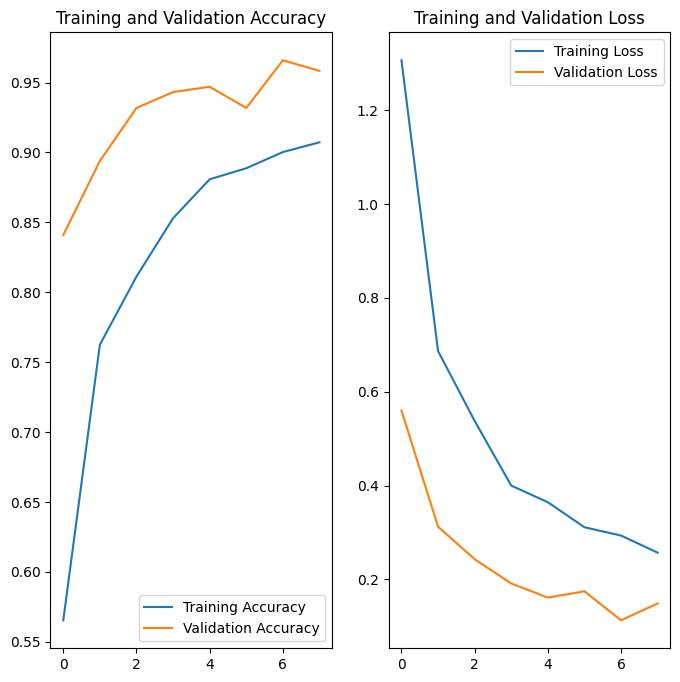

In [107]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

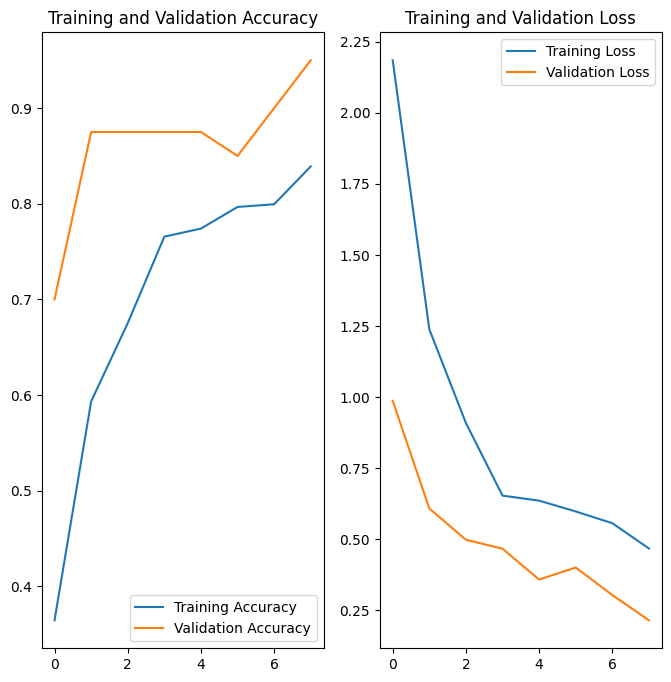

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: grasshopper
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: grasshopper


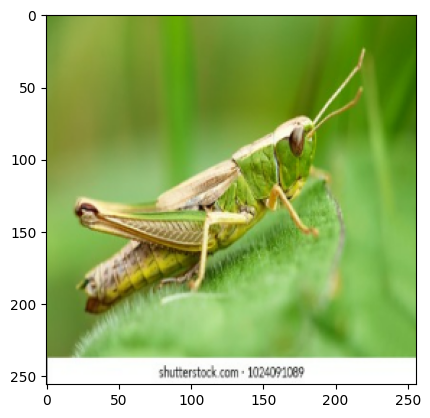

In [108]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [109]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


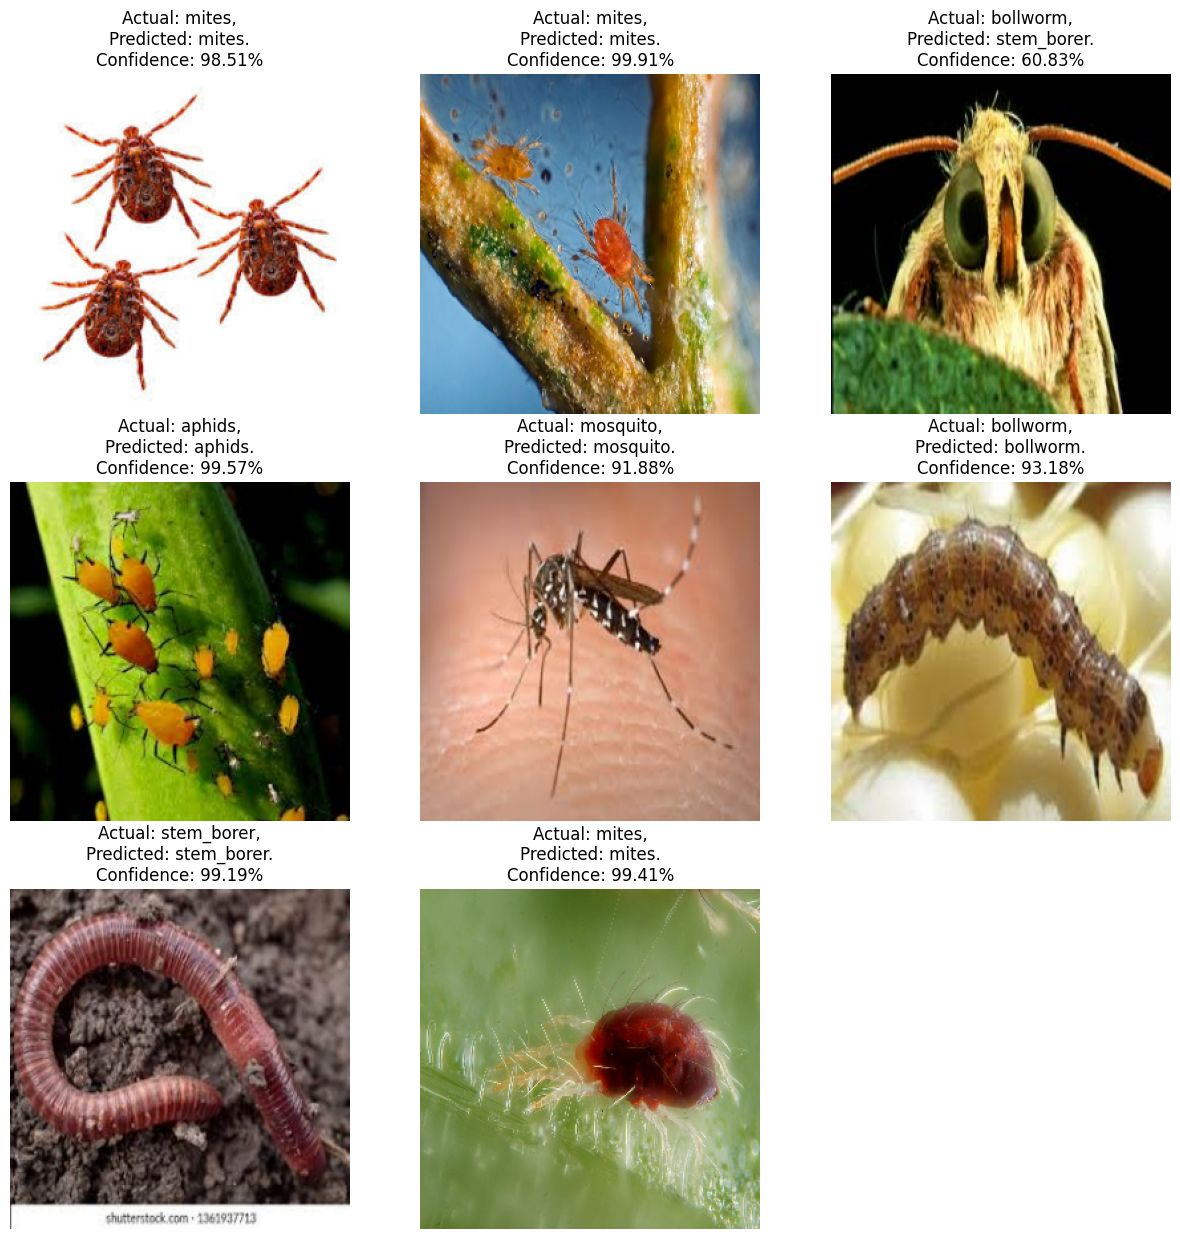

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    batch_size = images.shape[0]  # Get actual number of images in the batch
    num_images = min(9, batch_size)  # Ensure we don’t exceed available images

    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")

plt.show()  # Ensure proper display


In [111]:
import os
os.makedirs('/content/models', exist_ok=True)

In [112]:
model.save('/content/models/mobilenetv2_model.h5')  # HDF5 format